# Title: Linear Regression model

## Description:
In this file we are going to create a linear regression model to predict the total annual benefit of the trees.

In detail, we are going to:
1. Import the data
2. Clean the data
3. Create the model
4. Train the model
5. Evaluate the model

In [15]:
%matplotlib inline
import math
import matplotlib
import pandas
import glob
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
import seaborn as sns
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import geopandas as gpd
from sklearn.metrics import (
    mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



In [16]:
data = pd.read_csv('data_trees_modified.csv', sep=';')

export_eco = pd.read_csv('../data/reports/export_eco.csv', sep=';')

/var/folders/j8/fjrnp8w15sbf5q2fdgnpb0br0000gn/T/ipykernel_4552/4200321720.py:3: DtypeWarning: Columns (24,25,26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  export_eco = pd.read_csv('../data/reports/export_eco.csv', sep=';')


In [17]:
data.columns

Index(['Tree ID', 'Name', 'DBH (cm)', 'Replacement Value (eur)',
       'Carbon Storage (kg)', 'Carbon Storage (eur)',
       'Gross Carbon Sequestration (kg/yr)',
       'Gross Carbon Sequestration (eur/yr)', 'Avoided Runoff (l/yr)',
       'Avoided Runoff (eur/yr)', 'Carbon Avoided (kg/yr)',
       'Carbon Avoided (eur/yr)', 'Pollution Removal (g/yr)',
       'Pollution Removal (eur/yr)', 'Energy Savings (eur/yr)',
       'Total Annual Benefits (eur/yr)', 'Height (m)', 'Latitude',
       'Longitude'],
      dtype='object')

In [18]:
data.head(1)

,Tree ID,Name,DBH (cm),Replacement Value (eur),Carbon Storage (kg),Carbon Storage (eur),Gross Carbon Sequestration (kg/yr),Gross Carbon Sequestration (eur/yr),Avoided Runoff (l/yr),Avoided Runoff (eur/yr),Carbon Avoided (kg/yr),Carbon Avoided (eur/yr),Pollution Removal (g/yr),Pollution Removal (eur/yr),Energy Savings (eur/yr),Total Annual Benefits (eur/yr),Height (m),Latitude,Longitude
0,2,Common fig,23.622,1031.67,132.086098,21.22,10.387265,1.67,48.831789,0.09,0.0,NaN,0.031184,0.09,NaN,1.85,3.0,44.499234,11.30462


In [19]:
COLUMNS = ['Replacement Value (eur)', 'DBH (cm)', 'Height (m)', 'Gross Carbon Sequestration (kg/yr)', 'Avoided Runoff (l/yr)', 'Total Annual Benefits (eur/yr)', ]

#trees = pandas.read_csv('data/training_trees.csv', sep=';')
# create a subsample of data, the first 10000 rows

#trees = data.iloc[:50000, :]
trees = data
trees['Name_id'] = trees['Name'].astype('category').cat.codes

In [20]:
# Calculate the R-squared score between the 'Height (m)' and 'DBH (cm)' columns of the 'trees' DataFrame.
metrics.r2_score(trees['Height (m)'], trees['Total Annual Benefits (eur/yr)'])

-0.7781585083471076

A result of -0.7781585083471076 means that the independent variable (`Height (m)`) does not explain much of the variation in the dependent variable (`Total Annual Benefits (eur/yr)`). 

In fact, the negative value of the R-squared indicates that the model is performing worse than a horizontal line (i.e., a model that predicts the mean value of the dependent variable for all values of the independent variable). This suggests that there may be other factors that are influencing the `Total Annual Benefits (eur/yr)` column that are not captured by the `Height (m)` column alone.

Overall, a negative R-squared value indicates that the model is not a good fit for the data and that other factors may need to be considered in order to accurately predict the `Total Annual Benefits (eur/yr)` column.

In [21]:
# split the data into training and validation sets
# we are going to use the 'DBH (cm)' and 'Carbon Storage (kg)' columns as features
# and the 'Total Annual Benefits (eur/yr)' column as the target
x_train, x_validation, y_train, y_validation = train_test_split(
    trees[['DBH (cm)', 'Name_id', 'Latitude', 'Longitude', 'Height (m)']],
    trees['Total Annual Benefits (eur/yr)'],
    test_size=0.25,
)

regression = LinearRegression()
regression.fit(
    x_train,
    y_train,
)

print(mean_absolute_percentage_error(y_train, regression.predict(x_train)))
print(r2_score(y_train, regression.predict(x_train)))

42.00033040820757
0.6951903098847149


1.2006199397821524
0.69546000349666


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


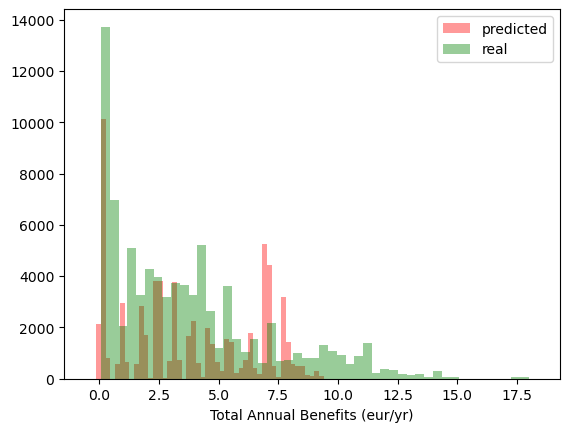

In [22]:
def get_reg(trees_df):
    x_train, x_validation, y_train, y_validation = train_test_split(
        trees_df[['DBH (cm)', 'Name_id', 'Latitude', 'Longitude', 'Height (m)']],
        #trees_df[['DBH (cm)', 'Height (m)', 'Avoided Runoff (l/yr)']],
        trees_df['Total Annual Benefits (eur/yr)'],
        test_size=0.2,
    )

    reg = LinearRegression()
    reg.fit(
        x_train,
        y_train,
    )
    mean_abs_err = mean_absolute_error(y_train, reg.predict(x_train))
    print(mean_abs_err)
    
    print(r2_score(y_validation, reg.predict(x_validation)))

    return reg, x_train

reg_o3, x_train = get_reg(trees)

a1, a2, a3, a4, a5, b = reg_o3.coef_[0], reg_o3.coef_[1], reg_o3.coef_[2], reg_o3.coef_[3], reg_o3.coef_[4], reg_o3.intercept_

fn = a1 * trees['DBH (cm)'] + a2 * trees['Name_id'] + a3 * trees['Latitude'] + a4 * trees['Longitude'] + a5 * trees['Height (m)'] + b

sns.distplot(reg_o3.predict(x_train), kde=False, bins=50, color='r', label='predicted')
sns.distplot(trees['Total Annual Benefits (eur/yr)'], kde=False, bins=50, color='g', label='real')
plt.legend()


The Huber Regressor is a type of robust regression model used in statistics and machine learning. It's designed to be less sensitive to outliers in the data compared to ordinary least squares (OLS) regression. In traditional linear regression, outliers can have a substantial impact on the regression coefficients and, consequently, the model's performance. The Huber Regressor addresses this issue by using a different loss function.

MErr: 6.361555964779056
R2:   0.28408019412266206


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


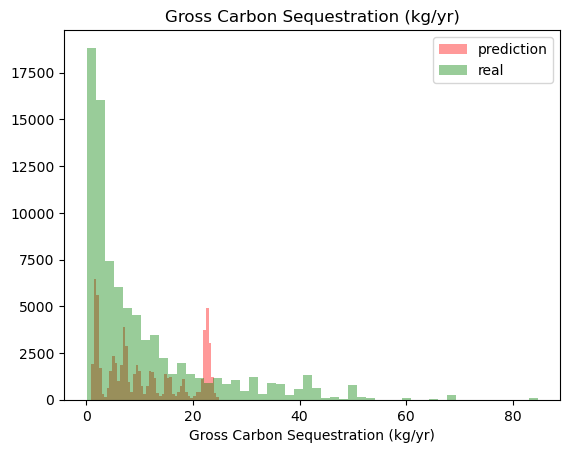

MErr: 120.37889747937666
R2:   0.8687328421296806


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


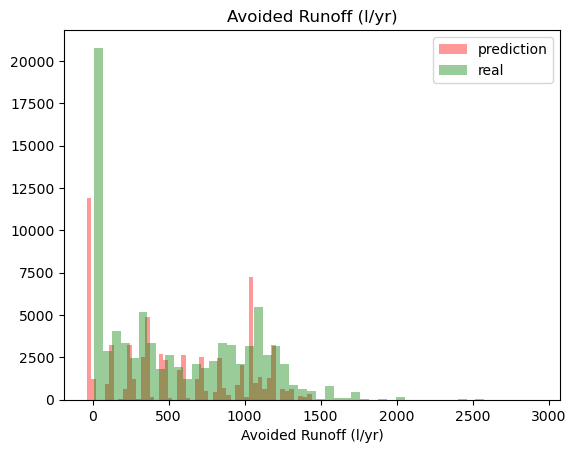

MErr: 1.1882665821170924
R2:   0.6912442503134344


/Users/luca/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


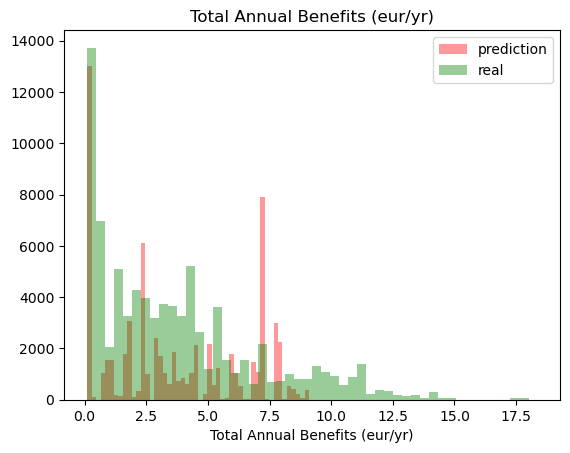

In [23]:
def get_reg(trees_df, factor):
    x_train, x_validation, y_train, y_validation = train_test_split(
        trees_df[['DBH (cm)', 'Name_id', 'Latitude', 'Longitude', 'Height (m)']],
        trees_df[factor],
        test_size=0.2,
        random_state=52,
    )

    reg = HuberRegressor()
    reg.fit(
        x_train,
        y_train,
    )
    mean_abs_err = mean_absolute_error(y_train, reg.predict(x_train))
    print(f'MErr: {mean_abs_err}')
    print(f'R2:   {r2_score(y_validation, reg.predict(x_validation))}')
    
    sns.distplot(reg.predict(x_train), kde=False, bins=50, color='r', label='prediction')
    sns.distplot(trees_df[factor], kde=False, bins=50, color='g', label='real')
    plt.title(factor) 
    plt.legend()
    plt.show()
    
    return reg

factors = ['Gross Carbon Sequestration (kg/yr)', 'Avoided Runoff (l/yr)', 'Total Annual Benefits (eur/yr)']
models = {}

for factor in factors:

    reg = get_reg(trees, factor)

    models[factor] = reg
    


## Spacial regression

## Plot regressions

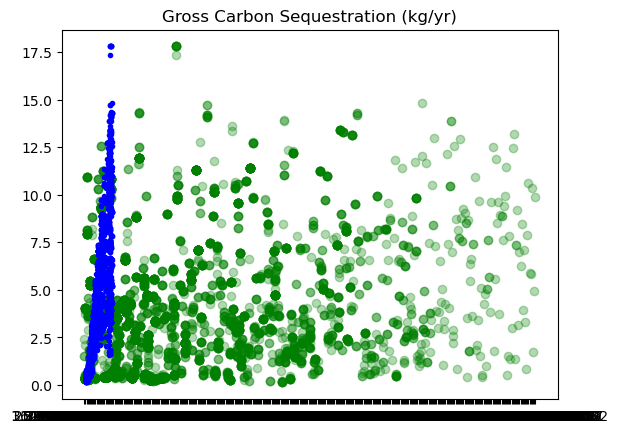

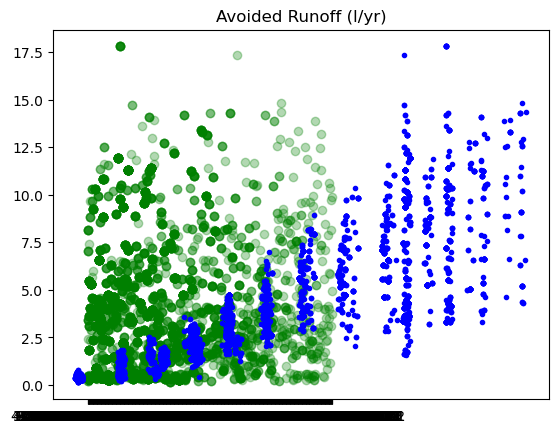

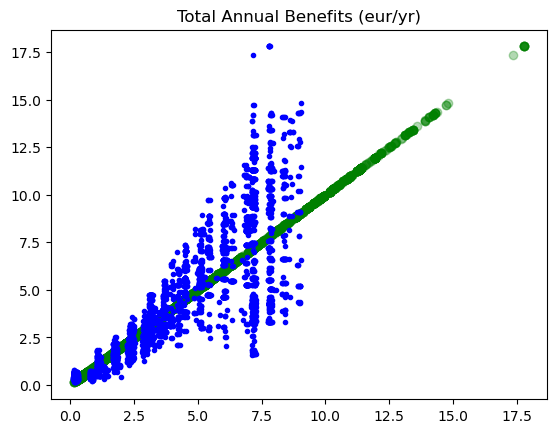

In [ ]:
def plot_regression(reg, trees_df, factor):
    a1, a2, a3, a4, a5, b = reg.coef_[0], reg.coef_[1], reg.coef_[2], reg.coef_[3], reg.coef_[4], reg.intercept_

    fn = a1 * trees_df['DBH (cm)'] + a2 * trees_df['Name_id'] + a3 * trees_df['Latitude'] + a4 * trees_df['Longitude'] + a5 * trees_df['Height (m)'] + b
    plt.plot(fn, trees_df['Total Annual Benefits (eur/yr)'], 'b.')
    plt.scatter(trees_df[factor], trees_df['Total Annual Benefits (eur/yr)'], c='g', alpha=0.3)
    plt.title(factor)
    plt.show()
    # blue is the regression line (predicted values)
    # green is the real values
    
trees["Total Annual Benefits (eur/yr)"] = trees["Total Annual Benefits (eur/yr)"].astype(float)
#trees_filtered['Carbon Storage (kg)'] = trees_filtered['Carbon Storage (kg)'].astype(float)
trees['DBH (cm)'] = trees['DBH (cm)'].astype(float)
trees["Height (m)"] = trees["Height (m)"].astype(float)

for factor, reg in models.items():
    plot_regression(reg, trees, factor)

The resulting plots will show the relationship between the independent variable specified by `factor` and the dependent variable (`Total Annual Benefits (eur/yr)`) for each regression model in the `models` dictionary. The blue dots represent the predicted values of the dependent variable based on the regression model, while the green dots represent the actual values of the dependent variable in the DataFrame.

By examining the plots, you can determine the strength and direction of the relationship between the independent variable and the dependent variable, as well as any potential outliers or patterns in the data. You can also compare the strength of the relationships between the different independent variables by comparing the slopes of the regression lines.

In [ ]:
data['DBH (cm)'] = data['DBH (cm)'] * math.pi
data['Latitude'] = np.sqrt(data['DBH (cm)'])

<AxesSubplot:xlabel='Total Annual Benefits (eur/yr)', ylabel='Density'>

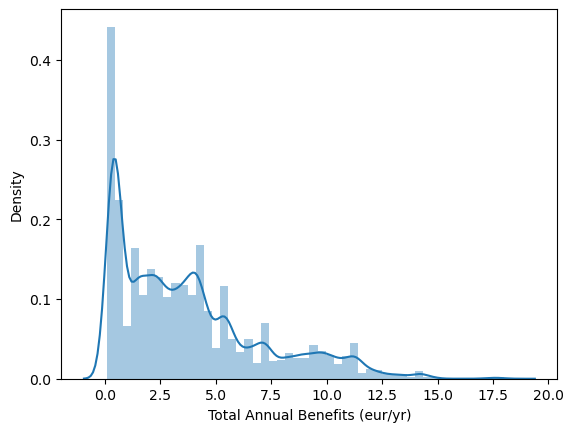

In [ ]:
sns.distplot(data['Total Annual Benefits (eur/yr)'], bins=50)

In [ ]:
data.describe()

,Tree ID,DBH (cm),Replacement Value (eur),Carbon Storage (kg),Carbon Storage (eur),Gross Carbon Sequestration (kg/yr),Gross Carbon Sequestration (eur/yr),Avoided Runoff (l/yr),Avoided Runoff (eur/yr),Carbon Avoided (kg/yr),Carbon Avoided (eur/yr),Pollution Removal (g/yr),Pollution Removal (eur/yr),Energy Savings (eur/yr),Total Annual Benefits (eur/yr),Height (m),Latitude,Longitude
count,84943.000000,84943.000000,84943.000000,84943.000000,84943.000000,84943.000000,84943.000000,84943.000000,84943.000000,84943.0,0.0,84943.000000,84943.000000,0.0,84943.000000,84943.000000,84943.000000,84943.000000
mean,66556.023628,117.175272,2894.997547,663.524812,106.606369,10.265916,1.649501,554.322819,1.054442,0.0,NaN,0.370129,1.038717,NaN,3.742811,9.037072,10.052942,11.347481
std,37964.216181,84.504831,3166.994539,992.944436,159.533443,12.337153,1.981960,469.476216,0.893213,0.0,NaN,0.313577,0.879837,NaN,3.282642,5.828789,4.014203,0.066585
min,2.000000,23.938936,72.590000,1.496855,0.240000,0.090718,0.010000,10.220607,0.020000,0.0,NaN,0.005670,0.020000,NaN,0.080000,3.000000,4.892743,3.457371
25%,32976.500000,53.463624,620.210000,35.108049,5.640000,1.995806,0.320000,70.030085,0.130000,0.0,NaN,0.048194,0.130000,NaN,0.910000,3.000000,7.311882,11.314873
50%,66888.000000,98.947602,1209.090000,155.037872,24.910000,5.352390,0.860000,440.243183,0.840000,0.0,NaN,0.294835,0.820000,NaN,2.990000,9.000000,9.947241,11.354266
75%,101333.500000,185.127772,4699.950000,877.837314,141.040000,13.335616,2.140000,970.200583,1.850000,0.0,NaN,0.649204,1.820000,NaN,5.310000,14.000000,13.606167,11.380442
max,129582.000000,251.358828,11010.880000,7024.331442,1128.580000,84.594977,13.590000,2926.879012,5.570000,0.0,NaN,1.953281,5.490000,NaN,18.370000,19.500000,15.854300,11.433451


### Ridge Regression:
Ridge regression is used when there is multicollinearity in the data, which means that the independent variables are highly correlated with each other. In this case, the OLS method may produce unstable and unreliable estimates of the coefficients. Ridge regression adds a penalty term to the sum of squared errors in the OLS method, which helps to reduce the variance of the estimates and improve the stability of the model.

In [ ]:

# WE ARE WORKING WITH A SAMPLE OF THE DATA
# Load your tree dataset with coordinates and ecological benefits
trees = gpd.read_file('../data/geojson/geo_data_trees.geojson')
# take a random sample of the dataset (1000 rows)
trees = trees.sample(n=5000)

# Create a Ridge regression model
model = Ridge()

trees['Name_id'] = trees['Name'].astype('category').cat.codes

# Select the dependent variable and independent variables
y = trees['Total Annual Benefits (eur/yr)'] # dependent
X = trees[['DBH (cm)', 'Name_id', 'Latitude', 'Longitude', 'Height (m)']] # independent
#X = trees[['Name_id']] # independent

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Create a hyperparameter grid for Ridge
ridge_grid = {'alpha': np.arange(0, 1, 0.01)}

# Tune the model using cross-validation
ridge_cv = GridSearchCV(model, ridge_grid, cv=5)
ridge_cv.fit(X_train, y_train)

# Find the best hyperparameters
print(ridge_cv.best_params_)
print(ridge_cv.best_score_)
print(ridge_cv.best_estimator_)
print(ridge_cv.best_index_)

{'alpha': 0.99}
0.6990861342459618
Ridge(alpha=0.99)
99
